# MC and Sarsa($\lambda$) Controls on Text Flappy Bird (TFB)
### Author : Adrien Fu
### Date : 28/03/2025

In [26]:
import os, sys
import gymnasium as gym
import time
from IPython.display import clear_output
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import text_flappy_bird_gym

In [27]:
# initiate environment
env = gym.make('TextFlappyBird-screen-v0', height = 15, width = 20, pipe_gap = 4)
# 2 Choices : 'TextFlappyBird-v0', 'TextFlappyBird-screen-v0'

### Test of the environment

We firstly test the TFB environment with random action.

In [28]:
obs, _ = env.reset()

# iterate
while True:

    # Select next action
    action = env.action_space.sample()

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)
    
    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS
    
    # Clear the output to make the frames dynamic
    clear_output(wait=True)

    # If player is dead break
    if done:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[               |    ]
[               |    ]
[               |    ]
[                    ]
[                    ]
[                    ]
[                    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[               |    ]
[     *         |    ]
^^^^^^^^^^^^^^^^^^^^^^
(Idle)


In [29]:
print(env.observation_space)
print(env.action_space)

Box(0, 3, (20, 15), int32)
Discrete(2)


- For `"TextFlappyBird-screen-v0"`, at time $t$, each observation $O_t$ is the complete screen render of the game (an array of size width x height). This array is filled of $0$, except for the position of the bird (number $1$) and the obstacles (located by the number $2$). When the bird hits an obstacle, it dies and the position has value $3$.

- At each time $t$, the bird has 2 choices of action : idle (__action__ = $0$) or flap (__action__ = $1$).

- Flapping allows the position of the bird to be 1 block higher, and idling makes the bird go lower for the next time step $t+1$. To be more precise, if the bird idles 3 times in a row, the first time the bird falls by 1 block, the second time by 2 blocks, and the third time by 3 blocks. 

- To define the __state__ from the observation, we define it as the vector $(x,y)$ that goes from the bird to the center of the closest upcoming pipe gap. That way, the trained agents can be used for `"TextFlappyBird-v0"`, as the observation in `"TextFlappyBird-v0"` is direclty the vector $(x,y)$.

## Section 1 :  Constant $\alpha$-MC control

We first write the function `mc_control` that is an implementation of constant-$\alpha$ MC control.

This algorithm has six arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate. It must be a value between $0$ and $1$, inclusive (default value: $1$).
- `get_score_every_it`: Every `get_score_every_it` episodes, we test the trained policy $100$ times, and get a mean score that will be used below to plot the evolution of the score when training.
- `max_reward_value`: When we test the trained policy, `max_reward_value` is the maximum value of the reward before going to the next iteration. This avoids too long testing time.

The algorithm returns:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.
- `L_mean_score`: A list of mean scores, where each one is from testing the policy $100$ times at a fixed episode.
- `L_std_score`: The list of standard deviations corresponding to `L_mean_score`.

In [30]:
def get_state(obs):
    """ gets the state from the observation """
    width, height = obs.shape
    
    # in the case the player is dead, return the state "dead"
    if 1 in obs:
        x_bird, y_bird = np.argwhere(obs == 1)[0]
    else:
        return "dead"
    
    # if the player is still alive, state = vector from bird to the center of the closest upcoming pipe gap
    for i in range(x_bird, width):
        if obs[i,0] == 2 or obs[i,-1] == 2:
            x_obstacle = i
            break
    for i in range(height):
        if obs[x_obstacle, i] == 0:
            for j in range(i,height):
                if obs[x_obstacle, j] == 2:
                    y_obstacle = (i+j)//2
                    break
    state = (x_obstacle-x_bird, y_obstacle-y_bird)
    return state


def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon /nA
    best_a = np.argmax(Q_s)
    
    policy_s[best_a] = 1 - epsilon + epsilon / nA
    return policy_s


def generate_episode_from_Q(env, Q, epsilon, nA, max_reward):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    obs, _ = env.reset()
    state = get_state(obs)
    
    for _ in range(max_reward):
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA))\
                                                    if state in Q else env.action_space.sample()
                
        next_obs, reward, done, _, _ = env.step(action)
        episode.append((state, action, reward))
        obs = next_obs
        state = get_state(obs)
        if done:
            break
    return episode

The function `one_play` below runs a game of TFB to test a policy. It has four arguments:

- `env`: This is an instance of an OpenAI Gym environment.
- `policy`: This is the tested policy.
- `graphic`: If `graphic = False`, the game runs with no FPS and returns the final score. If `graphic = True`, the game runs normally, and return nothing.
- `max_step`: The maximum number of steps before ending the game. This avoids too long testing time.

In [31]:
# function to test a policy in one game, returns a score if 
def one_play(env, policy, graphic = False, max_reward = 4000, FPS=5, return_type="score"):

    obs, _ = env.reset()
    
    sum_reward = 0
    for _ in range(max_reward):
        # Select next action
        state = get_state(obs)
        action = policy[state] if state in policy else env.action_space.sample()

        # Appy action and return new observation of the environment
        obs, r, done, _, info = env.step(action)
        sum_reward += r

        if graphic:
            # Clear the output to make things dynamic
            clear_output(wait=True)

            # Render the game
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(1/FPS) # FPS
            
        # If player is dead break
        if done:
            break
    env.close()
    
    if graphic == False:
        if return_type == "score":
            return info["score"]
        else:
            return sum_reward

In [32]:
def MC_update_Q(episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha * (sum(rewards[i:]*discounts[:-(1+i)])- old_Q)
    return Q


def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999,
               eps_min=0.05, get_score_every_it = 1000, max_reward = 4000):
    nA = env.action_space.n
    epsilon = eps_start
 
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    # retrieve the score every 1000 episodes, with the current policy
    L_mean_score = []
    L_std_score = []
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        if i_episode % get_score_every_it == 0:
            # policy test to get the sum of reward (limited to max_step  = 2000)
            policy = dict((k,np.argmax(v)) for k, v in Q.items())
            L_score = []
            for _ in range(100):
                L_score.append(one_play(env, policy, graphic = False, max_reward = max_reward))
            
            L_mean_score.append(np.mean(L_score))
            L_std_score.append(np.std(L_score))
            
        
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA, max_reward)
        # update the action-value function estimate using the episode
        Q = MC_update_Q(episode, Q, alpha, gamma)
        

    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    L_mean_score = np.array(L_mean_score)
    L_std_score = np.array(L_std_score)
    return Q, policy, L_mean_score, L_std_score

#### Training

In [63]:
# needs 3-9 mins to run this cell
MC_Q, MC_policy, MC_L_mean_score, MC_L_std_score = mc_control(env, num_episodes=20000, alpha=2e-3)

Episode 20000/20000.

In [64]:
L_score = []
for i in range(100):
    L_score.append(one_play(env, MC_policy, graphic = False))
print(f"Mean score with MC: {np.mean(L_score)}")

Mean score with MC: 118.41


#### Estimated optimal state-value functions and policy of MC

The function `plot_values` below shows the estimated optimal state-value functions and policy.

In [42]:
def plot_values(Q):

    x_coords, y_coords = zip(*Q.keys())  # Unpack the keys into x and y coordinates

    # Create a grid for plotting
    # Here, we assume the x and y coordinates form a grid from min to max values
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # Create the grid
    X, _ = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))

    # Create a value matrix based on the dictionary
    V0, V1, P = np.zeros_like(X), np.zeros_like(X), np.zeros_like(X)
    for (x, y), value in Q.items():
        x_idx = x - x_min  # Normalize the index
        y_idx = y - y_min  # Normalize the index
        V0[y_idx, x_idx] = value[0]
        V1[y_idx, x_idx] = value[1]
        P[y_idx, x_idx] = np.argmax(value)

    # Plot the grid using imshow (heatmap)

    plt.figure(figsize=(16, 7))

    plt.subplot(1,3,1)
    plt.imshow(V0, cmap='viridis', extent=[x_min, x_max, y_min, y_max], origin='lower', interpolation='nearest')
    plt.title(f"State-value function with action = 0 (Idle)")
    plt.xlabel("x coordinate to the pipe gap center")
    plt.ylabel("y coordinate to the pipe gap center")
    plt.colorbar()

    plt.subplot(1,3,2)
    plt.imshow(V1, cmap='viridis', extent=[x_min, x_max, y_min, y_max], origin='lower', interpolation='nearest')
    plt.title(f"State-value function with action = 1 (Flap)")
    plt.xlabel("x coordinate to the pipe gap center")
    plt.ylabel("y coordinate to the pipe gap center")
    plt.colorbar()

    plt.subplot(1,3,3)
    plt.imshow(P, cmap='viridis', extent=[x_min, x_max, y_min, y_max], origin='lower', interpolation='nearest')
    plt.title(f"Deterministic policy (1 = Flap, 0 = Idle)")
    plt.xlabel("x coordinate to the pipe gap center")
    plt.ylabel("y coordinate to the pipe gap center")
    plt.colorbar()
    
    plt.show()

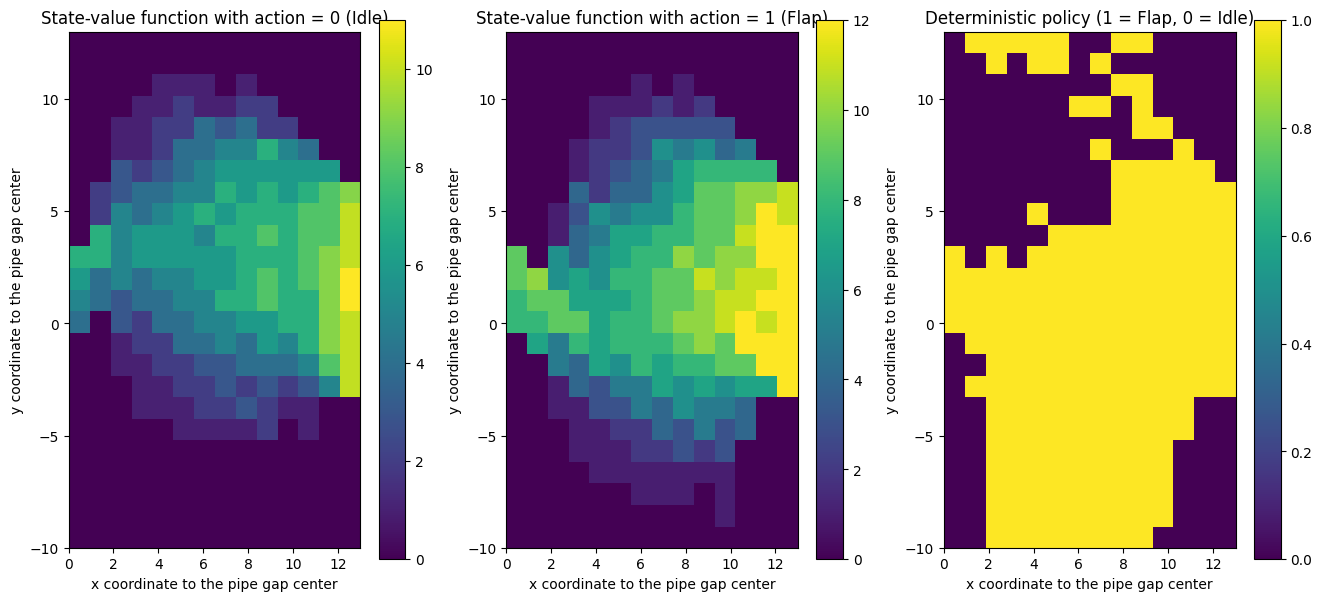

In [54]:
plot_values(MC_Q)

<u>Remark</u>: We have defined the policy as $\pi(s) = \text{argmax}_{a} Q(s,a)$, so each square of the heatmap of the policy is just the action that maximizes the same square in the state-value heatmaps.

#### To play TFB with `MC_policy`

In [44]:
# one_play(env, MC_policy, graphic = True, max_step = 4000, FPS=5)

## Section 2 : Sarsa($\lambda$)

Below is the function `lambda_sarsa` that is an implementation of Sarsa($\lambda$) control.

This algorithm has six arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate. It must be a value between $0$ and $1$, inclusive (default value: $1$).
- `lmbda`: This is the lambda parameter of the algorithm (default value: $0.9$).
- `get_score_every_it`: Every `get_score_every_it` episodes, we test the trained policy $100$ times, and get a mean score that will be used below to plot the evolution of the score when training.
- `max_reward_value`: When we test the trained policy, `max_reward_value` is the maximum value of the reward before going to the next iteration. This avoids too long testing time.

The algorithm returns:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.
- `L_mean_score`: A list of mean scores, where each one is from testing the policy $100$ times at a fixed episode.
- `L_std_score`: The list of standard deviations corresponding to `L_mean_score`.

In [45]:
def lambda_sarsa(env, num_episodes, alpha, gamma=1.0, lmbda=0.9, eps_start=1.0, eps_decay=.99999,
               eps_min=0.05, get_score_every_it = 1000, max_reward = 4000):
    
    nA = env.action_space.n
    epsilon = eps_start
 
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    # retrieve the score every 1000 episodes, with the current policy
    L_mean_score = []
    L_std_score = []
    
    for i_episode in range(1, num_episodes+1):
        
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            
        if i_episode % get_score_every_it == 0:
            # policy test to get the sum of reward (limited to max_step  = 2000)
            policy = dict((k,np.argmax(v)) for k, v in Q.items())
            L_score = []
            for _ in range(100):
                L_score.append(one_play(env, policy, graphic=False, max_reward=max_reward))
            
            L_mean_score.append(np.mean(L_score))
            L_std_score.append(np.std(L_score))
            
        
        epsilon = max(epsilon*eps_decay, eps_min)
            
        obs, _ = env.reset()
        state = get_state(obs)
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA))\
                                                    if state in Q else env.action_space.sample()
        
        E = defaultdict(lambda: np.zeros(nA))

        for _ in range(max_reward):
            next_obs, reward, done, _, _ = env.step(action)
            next_state = get_state(next_obs)

            delta = reward - Q[state][action]
            E[state][action] += 1 # accumulating traces
            
            if done:
                for s in Q.keys():
                    for a in range(nA):
                        Q[s][a] += alpha * delta * E[s][a] 
                break
            
            
            next_action = np.random.choice(np.arange(nA), p=get_probs(Q[next_state], epsilon, nA))\
                                                    if next_state in Q else env.action_space.sample()
                                                    
            delta += gamma * Q[next_state][next_action]
            
            for s in Q.keys():
                for a in range(nA):
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lmbda
            
            state = next_state
            action = next_action
            
    policy =  dict((k,np.argmax(v)) for k, v in Q.items())
    L_mean_score = np.array(L_mean_score)
    L_std_score = np.array(L_std_score)
    
    return Q, policy, L_mean_score, L_std_score

#### Training

In [46]:
# needs 3-9 mins to run this cell
sarsa_Q, sarsa_policy, sarsa_L_mean_score, sarsa_L_std_score = lambda_sarsa(env, num_episodes=20000, alpha=1e-2)

Episode 20000/20000.

In [47]:
L_score = []
for i in range(100):
    L_score.append(one_play(env, sarsa_policy, graphic = False))
print(f"Mean score with Sarsa: {np.mean(L_score)}")

Mean score with Sarsa: 282.71


#### Estimated optimal state-value functions and policy of Sarsa($\alpha$)

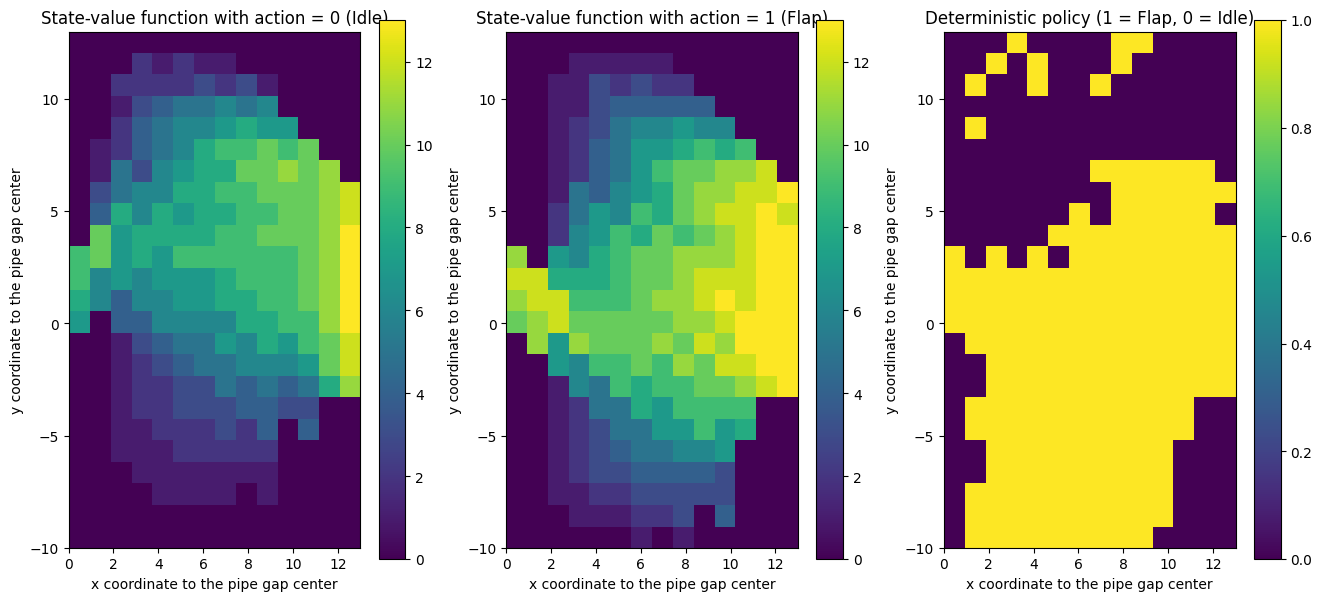

In [48]:
plot_values(sarsa_Q)

#### To play TFB with `sarsa_policy`

In [49]:
# one_play(env, sarsa_policy, graphic = True, max_step = 4000, FPS=5)

# Section 3 : Comparison between MC and Sarsa($\lambda$)

In this section, we would like to compare the performance of both algorithms applied in this problem. We study:
- Their score evolution during training (by using `MC_L_mean_score`, `MC_L_std_score`, `sarsa_L_mean_score`, `sarsa_L_std_score` obtained above).
- Their final score in function of $\alpha$ the step-size parameter. To be more precise, at a fixed stepsize, we train the agents in $10000$ episodes, then test $100$ times the policies to return the mean and standard devision scores.
- The influence of the environment configuration.

#### Score evolution during training

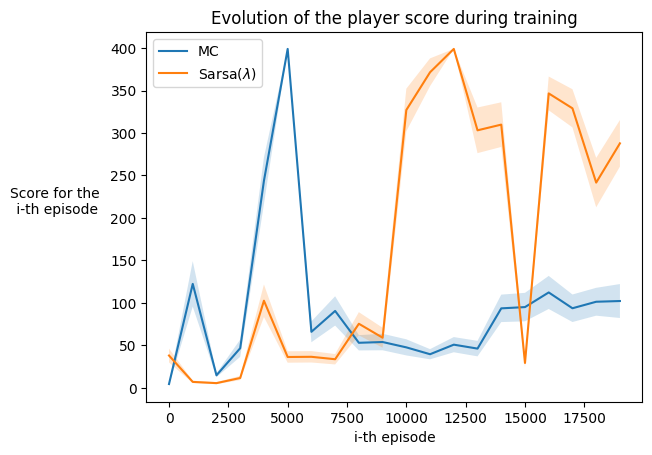

In [65]:
plt.plot([i*1000 for i in range(len(MC_L_mean_score))], MC_L_mean_score, label="MC")
plt.fill_between([i*1000 for i in range(len(MC_L_mean_score))], MC_L_mean_score + MC_L_std_score*0.2,
                 MC_L_mean_score - MC_L_std_score*0.2, alpha=0.2)

# *0.2 at the std because we ran n=100 times the algorithm to get the mean score, so with 95%:
# |mean_score - true_score| < std*2/sqrt(n) = 0.2 * std

plt.plot([i*1000 for i in range(len(sarsa_L_mean_score))], sarsa_L_mean_score, label=r"Sarsa($\lambda$)")
plt.fill_between([i*1000 for i in range(len(sarsa_L_mean_score))], sarsa_L_mean_score + sarsa_L_std_score*0.2,
                 sarsa_L_mean_score - sarsa_L_std_score*0.2, alpha=0.2)

plt.xlabel("i-th episode")
plt.ylabel("Score for the\n i-th episode",rotation=0, labelpad=40)
plt.title("Evolution of the player score during training")
plt.legend()
plt.show()

#### Final score in function of stepsize $\alpha$

In [66]:
# needs 15-20 mins to run this cell

L_step_sizes = np.logspace(-4, 0, num=10)

num_episodes = 10000

MC_L_score_stepsize = []
sarsa_L_score_stepsize = []
MC_L_std_score_stepsize = []
sarsa_L_std_score_stepsize = []


for i in range(len(L_step_sizes)):
    
    clear_output(wait=True)
    print(f"{i+1}-th iteration")
    
    _, mc_policy, _, _ = mc_control(env, num_episodes, alpha=L_step_sizes[i], get_score_every_it=num_episodes)
    
    _, s_policy, _, _ = lambda_sarsa(env, num_episodes, alpha=L_step_sizes[i], get_score_every_it=num_episodes)
    
    mc_L_score = []
    s_L_score = []
    for _ in range(100):
        mc_L_score.append(one_play(env, mc_policy, graphic = False))
        s_L_score.append(one_play(env, s_policy, graphic = False))
    
    MC_L_score_stepsize.append(np.mean(mc_L_score))
    MC_L_std_score_stepsize.append(np.std(mc_L_score))
    
    sarsa_L_score_stepsize.append(np.mean(s_L_score))
    sarsa_L_std_score_stepsize.append(np.std(s_L_score))

MC_L_score_stepsize = np.array(MC_L_score_stepsize)
sarsa_L_score_stepsize = np.array(sarsa_L_score_stepsize)
MC_L_std_score_stepsize = np.array(MC_L_std_score_stepsize)
sarsa_L_std_score_stepsize = np.array(sarsa_L_std_score_stepsize)

10-th iteration
Episode 10000/10000.

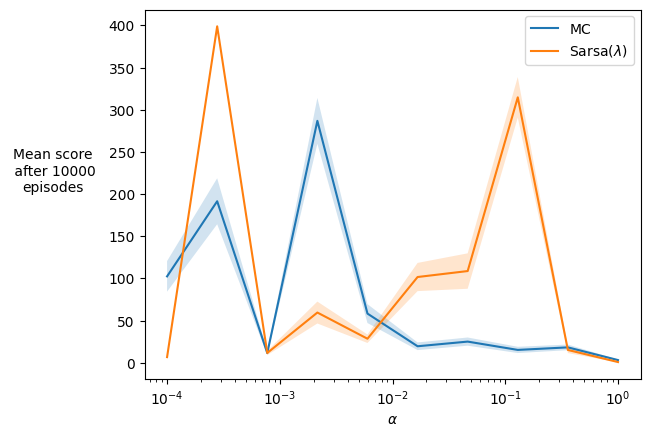

In [67]:
plt.plot(L_step_sizes, MC_L_score_stepsize, label="MC")
plt.fill_between(L_step_sizes, MC_L_score_stepsize + MC_L_std_score_stepsize*0.2,
                 MC_L_score_stepsize - MC_L_std_score_stepsize*0.2, alpha=0.2)

plt.plot(L_step_sizes, sarsa_L_score_stepsize, label=r"Sarsa($\lambda$)")
plt.fill_between(L_step_sizes, sarsa_L_score_stepsize + sarsa_L_std_score_stepsize*0.2,
                 sarsa_L_score_stepsize - sarsa_L_std_score_stepsize*0.2, alpha=0.2)

plt.xlabel(r"$\alpha$")
plt.ylabel(f"Mean score\n after {num_episodes}\nepisodes",rotation=0, labelpad=40)
plt.xscale("log")
plt.legend()
plt.show()

#### Final score in function of $\gamma$

In [68]:
# needs 14 mins to run this cell

L_gamma = np.logspace(-2, 0, num=10, endpoint=True)

num_episodes = 10000

MC_L_score_gamma = []
sarsa_L_score_gamma = []
MC_L_std_score_gamma = []
sarsa_L_std_score_gamma = []


for i in range(len(L_gamma)):
    
    clear_output(wait=True)
    print(f"{i+1}-th iteration")
    
    _, mc_policy, _, _ = mc_control(env, num_episodes, alpha=2e-3, gamma=L_gamma[i], 
                                    get_score_every_it=num_episodes)
    
    _, s_policy, _, _ = lambda_sarsa(env, num_episodes, alpha=2e-2, gamma=L_gamma[i], 
                                     get_score_every_it=num_episodes)
    
    mc_L_score = []
    s_L_score = []
    for _ in range(100):
        mc_L_score.append(one_play(env, mc_policy, graphic = False))
        s_L_score.append(one_play(env, s_policy, graphic = False))
    
    MC_L_score_gamma.append(np.mean(mc_L_score))
    MC_L_std_score_gamma.append(np.std(mc_L_score))
    
    sarsa_L_score_gamma.append(np.mean(s_L_score))
    sarsa_L_std_score_gamma.append(np.std(s_L_score))

MC_L_score_gamma = np.array(MC_L_score_gamma)
sarsa_L_score_gamma = np.array(sarsa_L_score_gamma)
MC_L_std_score_gamma = np.array(MC_L_std_score_gamma)
sarsa_L_std_score_gamma = np.array(sarsa_L_std_score_gamma)

10-th iteration
Episode 10000/10000.

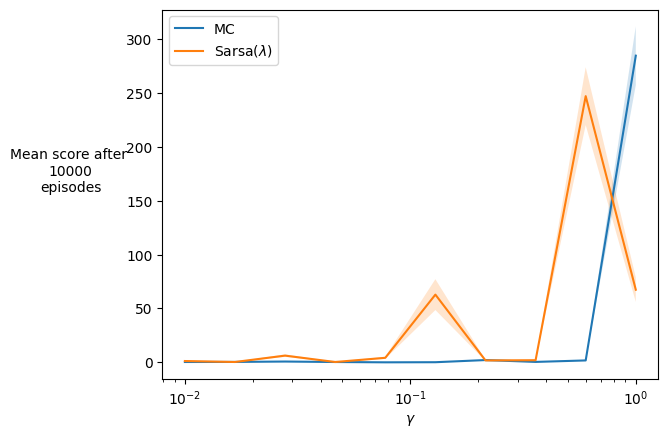

In [69]:
plt.plot(L_gamma, MC_L_score_gamma, label="MC")
plt.fill_between(L_gamma, MC_L_score_gamma + MC_L_std_score_gamma*0.2,
                 MC_L_score_gamma - MC_L_std_score_gamma*0.2, alpha=0.2)

plt.plot(L_gamma, sarsa_L_score_gamma, label=r"Sarsa($\lambda$)")
plt.fill_between(L_gamma, sarsa_L_score_gamma + sarsa_L_std_score_gamma*0.2,
                 sarsa_L_score_gamma - sarsa_L_std_score_gamma*0.2, alpha=0.2)

plt.xlabel(r"$\gamma$")
plt.ylabel(f"Mean score after \n{num_episodes}\nepisodes",rotation=0, labelpad=40)
plt.xscale("log")
plt.legend()
plt.show()

#### Final score in function of $\lambda$ (only for Sarsa)

In [70]:
# needs 10 mins to run this cell

L_lambda = np.logspace(-5, 0, num=10)

num_episodes = 10000

sarsa_L_score_lambda = []
sarsa_L_std_score_lambda = []


for i in range(len(L_lambda)):
    
    clear_output(wait=True)
    print(f"{i+1}-th iteration")
    
    _, s_policy, _, _ = lambda_sarsa(env, num_episodes, alpha=2e-3, lmbda=L_lambda[i],
                                    get_score_every_it=num_episodes)
    
    s_L_score = []
    for _ in range(100):
        s_L_score.append(one_play(env, s_policy, graphic = False))

    sarsa_L_score_lambda.append(np.mean(s_L_score))
    sarsa_L_std_score_lambda.append(np.std(s_L_score))

sarsa_L_score_lambda = np.array(sarsa_L_score_lambda)
sarsa_L_std_score_lambda = np.array(sarsa_L_std_score_lambda)

10-th iteration
Episode 10000/10000.

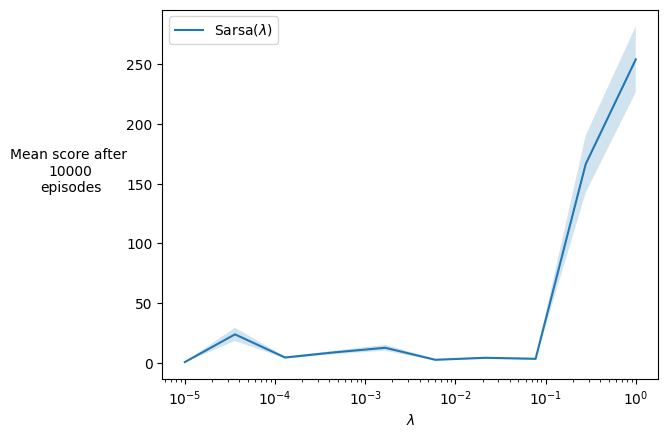

In [71]:
plt.plot(L_lambda, sarsa_L_score_lambda, label=r"Sarsa($\lambda$)")
plt.fill_between(L_lambda, sarsa_L_score_lambda + sarsa_L_std_score_lambda*0.2,
                 sarsa_L_score_lambda - sarsa_L_std_score_lambda*0.2, alpha=0.2)

plt.xlabel(r"$\lambda$")
plt.ylabel(f"Mean score after \n{num_episodes}\nepisodes",rotation=0, labelpad=40)
plt.xscale("log")
plt.legend()
plt.show()

<u>Remark</u>: The best value is $\lambda = 1.0$.

#### Other environments

We can still use the trained agents for 'TextFlappyBird-v0', if we change the y-axis orientation and rescale a little.

In [72]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
max_step = 4000

L_reward = []
for i in range(100):

    state, _ = env.reset()
    state_bis = (state[0],-1*state[1]+1)
    sum_reward = 0

    # iterate
    for _ in range(max_step):
        # Select next action
        action = sarsa_policy[state_bis] if state_bis in sarsa_policy else env.action_space.sample()
        # Appy action and return new observation of the environment
        state, reward, done, _, info = env.step(action)
        sum_reward += reward

        state_bis = (state[0],-1*state[1]+1)
        if done:
            break

    env.close()
    L_reward.append(sum_reward)
    
print(f"Mean total reward: {np.mean(L_reward)}")

Mean total reward: 2794.7


We try below different environment configuration by changing the window and the gap sizes.

In [73]:
env = gym.make('TextFlappyBird-screen-v0', height = 15, width = 20, pipe_gap = 2)

L_reward = []
for i in range(100):
    L_reward.append(one_play(env, sarsa_policy, graphic = False, return_type="reward"))
print(f"Mean total reward: {np.mean(L_reward)}")

Mean total reward: 12.73


In [74]:
env = gym.make('TextFlappyBird-screen-v0', height = 15, width = 20, pipe_gap = 8)

L_reward = []
for i in range(100):
    L_reward.append(one_play(env, sarsa_policy, graphic = False, return_type="reward"))
print(f"Mean total reward: {np.mean(L_reward)}")

Mean total reward: 4000.0


In [75]:
env = gym.make('TextFlappyBird-screen-v0', height = 20, width = 30, pipe_gap = 4)

L_reward = []
for i in range(100):
    L_reward.append(one_play(env, sarsa_policy, graphic = False, return_type="reward"))
print(f"Mean total reward: {np.mean(L_reward)}")

Mean total reward: 159.7


In [76]:
env = gym.make('TextFlappyBird-screen-v0', height = 10, width = 15, pipe_gap = 4)

L_reward = []
for i in range(100):
    L_reward.append(one_play(env, sarsa_policy, graphic = False, return_type="reward"))
print(f"Mean total reward: {np.mean(L_reward)}")

Mean total reward: 4000.0


- Agents work for bigger pipe gap, but not for smaller one.

- For the height and width, as much as the state $(x,y)$ is defined in the policy, the agents can be used. That's why the agents perform well on smaller windows and not on bigger ones (many states $(x,y)$ in big windows have never been seen by the agents during training).
